# Analyse dsync Notebook

## Abstract

Dans le cadre du projet d'analyse de la désynchronisation dans l'immprovisation musicale ...

## Experiments

The experiments were carried out over 3 sessions *data-yyyy-mm-dd*, with each session corresponding to a series of experiments *n__d_yyyy_mm_dd_t_hh_mm_ss*. 
There are 6 musicians, and each musician participating in the experiment has 2 acquisition devices (**riots**), one always on the head and the other on the arm or leg, depending on the session. There are therefore a total of 12 acquisition devices in an experiment. In addition, a trial (experiment) has 2 factors (or conditions)  

An acquisition device has :

* 3 sensors: accelerometer (**acc**) gyroscope (**gyro**) and magnetometer (**mag**) on 3 axes each
* 3 metrics : 
  **orientation** on 3 axes, device angle relative to gravitational axis
  * filtered acceleration (**accfilt**) on 3 axes, low-pass filter (~10 Hz) for accelerometer data to eliminate unwanted micro-variations
  **intensity**, normalization of the quantity of motion, "softened" representation of the recorded motion

There are therefore a total of 16 metrics per device per musician.

a sound file of the performance; depending on the session, this includes the sound of one or more metronomes, the sound "changes".

a video of the performance

a *riots-musicians.txt* file associating each riot with a musician and its type 

a *trials-info.txt* file associating the conditions of each experiment

A session also includes calibration recordings, improvisations and tests.

Translated with DeepL.com (free version)

## Datas

Stored in *.txt* format for each riot, sampled at 10ms, the data includes :

| Time Stamp | acc_x | acc_y | acc_z | gyro_x | gyro_y | gyro_z | mag_x | mag_y | mag_z | orientation_x | orientation_y | orientation_z | accfilt_x | accfilt_y | accfilt_z | intensity |
| ---------- | ----- | ----- | ----- | ------ | ------ | ------ | ----- | ----- | ----- | ------------- | ------------- | ------------- | --------- | --------- | --------- | --------- |

Data must be truncated in time, as they include biased data before and after performance.

## Code 

### Imports

#### Data Manipulation and Analysis

1.  **Numpy (`import numpy as np`)**: A fundamental package for numerical computing in Python.
    
2.  **Pandas (`import pandas as pd`)**: A library providing high-performance, easy-to-use data structures, and data analysis tools.

#### Data Visualization

1.  **Matplotlib (`import matplotlib.pyplot as plt`)**: A comprehensive library for creating static, interactive, and animated visualizations in Python.
    
2.  **Seaborn (`import seaborn as sns`)**: A statistical data visualization library based on Matplotlib.
    

#### Audio Processing

1.  **Librosa (`import librosa`, `import librosa.display`)**: A Python package for music and audio analysis.
    
2.  **SciPy (`from scipy import signal`, `import scipy as sp`)**: An open-source Python library used for scientific and technical computing. The `signal` module is specifically used for signal processing tasks, such as filtering or convolution.
    

#### File and System Operations

1.  **Glob (`import glob`)**: A module that finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
    
2.  **OS (`import os`)**: Provides a way of using operating system-dependent functionality.
    
3.  **Pickle (`import pickle`)**: Implements binary protocols for serializing and de-serializing a Python object structure.
    

#### Memory Management

1.   **Garbage Collector (`import gc`)**: Provides an interface to the garbage collector for Python objects.

#### Interactive Widgets and Displays

1.   **IPyWidgets (`import ipywidgets as widgets`, `from ipywidgets import interact, interactive, fixed, interact_manual`)**: Provides interactive HTML widgets for Jupyter notebooks. 
    
2.   **IPython Display (`from IPython.display import Audio, display, clear_output`)**: Facilitates rich media representation in Jupyter notebooks.
    
3.   **Regular Expressions (`import re`)**: Provides regular expression matching operations similar to those found in Perl.
    
4.   **Matplotlib Scale (`from matplotlib import scale`)**: While this specific import is unusual (as scales are typically used as part of plots directly), it might be aimed at customizing the scale of an axis in a plot.

In [18]:
#imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="darkgrid")
# sns.color_palette(palette="colorblind")

import scipy as sp
import librosa
import librosa.display


import glob
import os
import pickle

import gc
import re

import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Audio, display, clear_output

### Data structures

Data structures must have a scalable organization, optimized to avoid redundancy and to speed up searching; the structure is "trivial" for other, lower-level programming languages.
Data structures can be organized as follows:

* class Session:
    * date: string (date)
    * experiences: dict of Experience (from 1 to 24 or 32 (number of trials))

* class Experience:
    * time: string (time)
    * number: int
    * musician_riots: dictionary { musician: (riot_head, riot_limb) }
    * riots: dict of Riot (instead of list)
    * factors: tuple of string ('same' | 'close' | 'high' | 'low' ,'Yes' | 'No' | 'All' | musician)

* class Riot:
    * dataset: dict Dataset (instead of list, from 0 to N)
    * duration : float
    * trunc: (start: float, end: float)
    * riot_type: "arm" | "leg" | "head"

* class Dataset:
    * t: float
    * acc_x: float
    * acc_y: float
    * acc_z: float
    * gyro_x: float
    * gyro_y: float
    * gyro_z: float
    * mag_x: float
    * mag_y: float
    * mag_z: float
    * orientation_x: float
    * orientation_y: float
    * orientation_z: float
    * accfilt_x: float
    * accfilt_y: float
    * accfilt_z: float
    * intensity: float

In [19]:
# data structure for object-based data representation
class Session:
    def __init__(self, date, experiences=None):
        self.date = date
        if(experiences is None):
            experiences = {}
        self.experiences = experiences

class Experience:
    def __init__(self, time, number,musician_riots={},riots=None):
        self.time = time
        self.number = number
        # WARNING : Mutable default argument, all instance of experience point on the same instance of musician_riots dictionnary
        self.musician_riots = musician_riots
        if(riots is None):
            riots = {}
        self.riots = riots
        self.trunc = (0,0)
        self.info = ('','')

class Riot:
    def __init__(self, dataset, duration, riot_type):
        self.dataset = dataset
        self.duration = duration
        # trunc into experiences instead in riots
        # self.trunc = trunc
        self.riot_type = riot_type

class Dataset:
    def __init__(self, t, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, orientation_x, orientation_y, orientation_z, accfilt_x, accfilt_y, accfilt_z, intensity):
        self.t = t
        self.acc_x = acc_x
        self.acc_y = acc_y
        self.acc_z = acc_z
        self.gyro_x = gyro_x
        self.gyro_y = gyro_y
        self.gyro_z = gyro_z
        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z
        self.orientation_x = orientation_x
        self.orientation_y = orientation_y
        self.orientation_z = orientation_z
        self.accfilt_x = accfilt_x
        self.accfilt_y = accfilt_y
        self.accfilt_z = accfilt_z
        self.intensity = intensity
        
    def __str__(self):
        return f"t: {self.t}, acc_x: {self.acc_x}, acc_y: {self.acc_y}, acc_z: {self.acc_z}, gyro_x: {self.gyro_x}, gyro_y: {self.gyro_y}, gyro_z: {self.gyro_z}, mag_x: {self.mag_x}, mag_y: {self.mag_y}, mag_z: {self.mag_z}, orientation_x: {self.orientation_x}, orientation_y: {self.orientation_y}, orientation_z: {self.orientation_z}, accfilt_x: {self.accfilt_x}, accfilt_y: {self.accfilt_y}, accfilt_z: {self.accfilt_z}, intensity: {self.intensity}"


### Datas loading

TODO C version to speedup

In [20]:
# function to load data in object-based representation
def load_data(session_folder):
    # Extract date from folder name
    date = session_folder.split('-',1)[-1]
    session = Session(date)

    
    musicians_info_path = os.path.join(session_folder, 'riots-musicians.txt')
    musician_info = {}
    musician_riots = {}

    trials_info_path = os.path.join(session_folder, 'trials-info.txt')
    trials_info = []

    # Load musician and riot info
    with open(musicians_info_path, 'r') as file:
        for line in file:
            riot_number, musician, riot_type = line.strip().split()
            musician_info[int(riot_number)-1] = (musician, riot_type)
            
           # musician already in dict
            if musician not in musician_riots:
                musician_riots[musician] = (None, None)
            
            if riot_type == 'head':
                musician_riots[musician] = (int(riot_number)-1, musician_riots[musician][1])
            elif riot_type in ['arm', 'leg']:
                if musician_riots[musician][1] is None:
                    musician_riots[musician] = (musician_riots[musician][0], int(riot_number)-1)

     # Load trials info
    with open(trials_info_path, 'r') as file:
        for line in file:
            factor1, factor2 = line.strip().split()
            trials_info.append((factor1,factor2))
    
    # load experiment's datas
    for exp_file in glob.glob(f'{session_folder}/*-data-riot-*.txt'):
        exp_info = os.path.basename(exp_file).split('_')
        exp_number = int(exp_info[0])
        exp_time = re.search(r't_(\d+_\d+_\d+)-data', exp_file).group(1).replace('_', ':')
        riot_number = int(exp_info[-1].split('.')[0].split('-')[-1]) - 1
        
        experience = None
        if exp_number in session.experiences:
            experience = session.experiences[exp_number]
        else:
            experience = Experience(exp_time,exp_number)
            experience.musician_riots = musician_riots
            experience.info = trials_info[exp_number-1]
            session.experiences[exp_number] = experience
        
        # Read from each riots
        datasets = []
        with open(exp_file, 'r') as file:
            for line in file:
                data = list(map(float, line.strip().split()))
                dataset = Dataset(*data)
                datasets.append(dataset)
        
        duration = max([d.t for d in datasets])
        session.experiences[exp_number].trunc = (0,max(duration,session.experiences[exp_number].trunc[1]))
        
        riot = Riot(datasets, duration, musician_info[riot_number][1])
        session.experiences[exp_number].riots[riot_number] = riot
        
    return session


### Building Dataframe 

TODO

class Dataf (extend Dataset): 
  * exp_n: int
  * riot_n: int
  * musician: string
  * riot_type: "arm" | "leg" | "head"

In [21]:
class Dataf(Dataset):
    def __init__(self,dataset,exp_n,riot_n,musician,riot_type,trials_info):
        Dataset.__init__(self,dataset.t,dataset.acc_x,dataset.acc_y,dataset.acc_z,dataset.gyro_x,dataset.gyro_y,dataset.gyro_z,dataset.mag_x,dataset.mag_y,dataset.mag_z,dataset.orientation_x,dataset.orientation_y,dataset.orientation_z,dataset.accfilt_x,dataset.accfilt_y,dataset.accfilt_z,dataset.intensity)
        self.exp_n = exp_n
        self.riot_n = riot_n
        self.musician = musician
        self.riot_type = riot_type
        self.factor1, self.factor2 = trials_info

In [22]:
def session_to_dataf(session):
    # Construire les objets Dataf en prenant compte du tronquage
    datasetsf = []

    # for exp in session.experiences:      
    #     experience = session.experiences[exp]
    #     for musician in list(experience.musician_riots.keys()):
    #         riot_head, riot_limb = experience.musician_riots[musician]
    #         datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_head].riot_type) for data in experience.riots[riot_head].dataset if (experience.trunc[0] <= data.t <=experience.trunc[1])]
    #         datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_limb].riot_type) for data in experience.riots[riot_limb].dataset if (experience.trunc[0] <= data.t <=experience.trunc[1])]
    
    # Cette algo tiens compte du fait que les données sont rangé par ordre croissant
    for exp in session.experiences:      
        experience = session.experiences[exp]
        for musician in list(experience.musician_riots.keys()):
            riot_head, riot_limb = experience.musician_riots[musician]
            
            # Pour riot_head
            for data in experience.riots[riot_head].dataset:
                if data.t > experience.trunc[1]:
                    break  # Arrêtez l'itération si data.t dépasse la limite de temps supérieure
                if experience.trunc[0] <= data.t:
                    datasetsf.append(Dataf(data,experience.number,riot_head,musician,experience.riots[riot_head].riot_type,experience.info))
            
            # Pour riot_limb
            for data in experience.riots[riot_limb].dataset:
                if data.t > experience.trunc[1]:
                    break  # Arrêtez l'itération si data.t dépasse la limite de temps supérieure
                if experience.trunc[0] <= data.t:
                    datasetsf.append(Dataf(data,experience.number,riot_limb,musician,experience.riots[riot_limb].riot_type,experience.info))
    
    # Utilisation de l'introspection pour construire la liste des dictionnaires
    data_dicts = [vars(dataset) for dataset in datasetsf]

    # Création du DataFrame Pandas
    return pd.DataFrame(data_dicts)
            

### Exemple

Display waveform of the intensity of Cello over time in experience 10

In [23]:
#Load data in object based, convert to dataframe

# data_folder = "../data/"
# session2_folder = data_folder + 'data-2023-09-28'

# session = load_data(session2_folder)
# df = session_to_dataf(session)

In [24]:
# Plot Intensity of some riot

# filtered_df_Cello = df[(df['musician'] == 'Cello') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Cello, x='t', y='intensity', label='Intensity for Cello (Head) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# filtered_df_Drum = df[(df['musician'] == 'Drum') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Drum, x='t', y='intensity', label='Intensity for Drum (Arm) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# filtered_df_Sax = df[(df['musician'] == 'Sax') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Sax, x='t', y='intensity', label='Intensity for Sax (Arm) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# filtered_df_Sax = df[(df['musician'] == 'Piano') & (df['riot_type'] == 'head') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Sax, x='t', y='intensity', label='Intensity for Piano (Head) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

### Make data preparation interactive

In [25]:
# interactive code to truncate datas
%matplotlib inline


data_folder = "../data/"
cache_folder = "../data/cache/"
session_folder = ""
session = None
df = None
sound_file_path = ""
session_folders = []

save_name = ""

# Sauvegarde

def save_session(session,str=''):
    global save_name
    if(save_name == ""):
        save_name = '../data/cache/data-' + session.date + str + '.pickle'
    else:
        save_name = '../data/cache/' + save_name + '.pickle'
    with open(save_name, 'wb') as fichier:
        pickle.dump(session, fichier)

def load_session(session_path):
    with open(session_path, 'rb') as fichier:
        return pickle.load(fichier)
    return None

# Widgets
# Liste tous les dossiers dans data_folder
session_folders = [f.name for f in os.scandir(data_folder) if f.is_dir()]
session_select = widgets.Dropdown(
    options=['Sélectionnez un dossier de session'] + session_folders,
    description='Sessions:',
    disabled=False
)
saved_folders = [f for f in os.listdir(cache_folder) if f.endswith('.pickle')]
saved_select = widgets.Dropdown(
    options=['Sélectionnez une sauvegarde de session'] + saved_folders,
    description='Saves:',
    disabled=False
)
sound_dropdown = widgets.Dropdown(
    options=['Sélectionnez un dossier de session'],
    description='Fichiers son:',
    disabled=False,)

def update_sound_dropdown(session_folder):
    sound_files = sorted( [f for f in os.listdir(os.path.join(session_folder, 'sound')) if f.endswith('.aif')],key=lambda str: int(str.split('_',1)[0]))
    if sound_files:
        sound_dropdown.options = ['Sélectionnez un son'] + sound_files
    else:
        sound_dropdown.options = ['Aucun fichier trouvé']

def on_session_change(change):
    global df
    global session
    global session_folder
    session_folder = os.path.join(data_folder, change['new'])
    # Mise à jour du menu déroulant pour les fichiers sonores
    update_sound_dropdown(session_folder)
    print("chargement du dataframe ...")
    session = load_data(session_folder)
    df = session_to_dataf(session)
    # save_session(session)
    print("chargement du dataframe Terminé")
    
def on_saved_change(change):
    global df
    global session
    global session_folder
    
    print("chargement du dataframe ...")
    session = load_session(os.path.join(cache_folder, change['new']))
    df = session_to_dataf(session)
    # save_session(session)
    print("chargement du dataframe Terminé")
    session_folder = os.path.join(data_folder,'data-'+session.date)
    # Mise à jour du menu déroulant pour les fichiers sonores
    update_sound_dropdown(session_folder)
    
ui_active = False

def on_sound_change(change):
    global sound_file_path, ui_box, ui_active
    if change['new'] != 'Sélectionnez un son':
        if ui_active == False:
            ui_active = True
            display(ui_box)
            
        start_end_slider.unobserve(update_selection, names='value')
        sound_file_path = change['new']
        setup_waveform_trunc(os.path.join(data_folder, session_folder,"sound",sound_file_path))

# Widgets callback
session_select.observe(on_session_change, names='value')
saved_select.observe(on_saved_change, names='value')
sound_dropdown.observe(on_sound_change, names='value')

# Widgets display
display(session_select,saved_select)
display(sound_dropdown)

# Pour tronquer la waveform

# Lier la lecture à l'appui sur le bouton
def on_play_button_clicked(b):
    play_audio(start_end_slider.value[0], start_end_slider.value[1], audio, sr)


# Tronquage des datas

def on_trunc_button_clicked(b):
    global df, session
    # Tronquage directement à l'update de la selection, tout est donc Tronqué automatiquement
        #Màj de l'objet session directement (attention seconde -> milliseconde)
        # session.experiences[int(sound_file_path.split("_",1)[0])].trunc = (start_end_slider.value[0] * 1000, start_end_slider.value[1] * 1000)
        
    # Màj du dataframe
    print("mis à jour du dataframe ...")
    df = session_to_dataf(session)
    save_session(session)
    print("mis à jour du dataframe Terminé")


out = widgets.Output()

# Définir la fonction de lecture audio
def play_audio(start_time, end_time, audio, sr):
    display(Audio(data=audio[int(start_time * sr):int(end_time * sr)], rate=sr))

# Créer la fonction de mise à jour de la sélection
def update_selection(change):
    global session
    #Màj de l'objet session (attention seconde -> milliseconde)
    session.experiences[int(sound_file_path.split("_",1)[0])].trunc = (change['new'][0] * 1000, change['new'][1] * 1000)

    with out:
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr, color='blue')
        plt.axvspan(change['new'][0], change['new'][1], color='red', alpha=0.5)
        plt.show()
        
# Créer les widgets pour contrôler la lecture et le tronquage
start_end_slider = widgets.FloatRangeSlider(
    min=0, 
    step=0.01, 
    description='Time Range (s):',
    continuous_update=False,
)
start_end_slider.layout.width = '50%'
play_button = widgets.Button(description="Play")
trunc_button = widgets.Button(description="Trunc")
trunc_button.on_click(on_trunc_button_clicked)

play_button.on_click(on_play_button_clicked)

# textbox pour sauvegarde
def update_save_name(change):
    global save_name
    save_name = change['new']
    

save_tbox = widgets.Text(
    value=save_name,
    placeholder='Nom de Sauvegarde',
    description='Save:',
    disabled=False   
)
save_tbox.observe(update_save_name, names='value')


ui_box = widgets.VBox([start_end_slider, play_button, trunc_button,save_tbox, out], layout={'width': '100%'})

# Créer la fonction pour configurer et afficher le waveform avec les contrôles
def setup_waveform_trunc(audio_path):
    global audio, sr, session
    
    # Charger le fichier audio
    audio, sr = librosa.load(audio_path)

    # Mise à jour des widgets pour contrôler la lecture et le tronquage
    start_end_slider.max = len(audio) / sr
    start_end_slider.value=[session.experiences[int(sound_file_path.split("_",1)[0])].trunc[0]/1000, session.experiences[int(sound_file_path.split("_",1)[0])].trunc[1]/1000]
    # Lier la mise à jour de la sélection aux changements de valeur des curseurs
    start_end_slider.observe(update_selection, names='value')
    
    # Initialiser l'affichage
    with out:
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr, color='blue')
        plt.axvspan(start_end_slider.value[0], start_end_slider.value[1], color='red', alpha=0.5)
        plt.show()
    
# %matplotlib inline

Dropdown(description='Sessions:', options=('Sélectionnez un dossier de session', 'cache', 'csv', 'data-2023-09…

Dropdown(description='Saves:', options=('Sélectionnez une sauvegarde de session', 'change.pickle', 'click_temp…

Dropdown(description='Fichiers son:', options=('Sélectionnez un dossier de session',), value='Sélectionnez un …

### Load or Save CSV Dataframe

In [26]:
# interactive code to load/save csv
csv_path = '../data/csv/'

# Fonction pour charger les données CSV
def _load_csv(filename):
    global df
    full_path = os.path.join(csv_path, filename)
    if os.path.isfile(full_path):
        df = pd.read_csv(full_path)
        print("Fichier chargé avec succès. Aperçu des données :")
        display(df.head())
    else:
        print("Le fichier spécifié n'existe pas.")

def load_csv(filename):
    full_path = os.path.join(csv_path, filename)
    if os.path.isfile(full_path):
        dframe = pd.read_csv(full_path)
        print("Fichier chargé avec succès. Aperçu des données :")
        display(dframe.head())
        return dframe
    else:
        print("Le fichier spécifié n'existe pas.")
        return None

# Fonction pour sauvegarder les données dans un fichier CSV
def save_csv(b):
    file_name = save_text.value
    if file_name == '': return
    if df.empty:
        print("Le DataFrame est vide. Veuillez charger des données avant de sauvegarder.")
        return
    df.to_csv(os.path.join(csv_path, file_name + ".csv"), index=False)
    print(f"Les données ont été sauvegardées dans {file_name}.csv")

# Interface utilisateur pour le chargement de fichiers CSV
def file_selector(folder_path=csv_path):
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    selected_file = widgets.Dropdown(options=filenames, description='Fichiers CSV:')
    return selected_file

# Création du widget de sélection de fichier pour le chargement
file_dropdown = file_selector()
load_button = widgets.Button(description="Charger")
load_button.on_click(lambda b: _load_csv(file_dropdown.value))

# Création du widget de texte et bouton pour la sauvegarde
save_text = widgets.Text(
    value='',
    placeholder='Nom du fichier CSV',
    description='Sauver CSV:',
    disabled=False
)
save_button = widgets.Button(description="Sauvegarder")
save_button.on_click(save_csv)

# Affichage des widgets
display(file_dropdown, load_button, save_text, save_button)

# Interface utilisateur pour la sauvegarde de fichiers CSV
# interact(save_csv, file_name='')

Dropdown(description='Fichiers CSV:', options=('change_all.csv', 'change_intensity.csv', 'click_tempo_all.csv'…

Button(description='Charger', style=ButtonStyle())

Text(value='', description='Sauver CSV:', placeholder='Nom du fichier CSV')

Button(description='Sauvegarder', style=ButtonStyle())

#### ❗ Clear Memory

In [27]:
# add everything to free here
session = None
audio = None

columns_to_drop = ['acc_x' , 'acc_y' , 'acc_z' , 'gyro_x' , 'gyro_y' , 'gyro_z' , 'mag_x' , 'mag_y' , 'mag_z' , 'orientation_x' , 'orientation_y' , 'orientation_z' , 'accfilt_x' , 'accfilt_y' , 'accfilt_z']

def clear_df(df,columns):
    return df.drop(columns,axis=1)

plt.close('all')

# df = clear_df(df,columns_to_drop)

gc.collect()

387

## Analysis
basic statistics ,wavelet transform, correlation, cross-correlation, Fourrier Transform, spectral analysis, tempi/rhytmic analysis, Granger causality

### Distribution of movement

D'abord analyser la distribution du mouvement (pour une expérience) par instrument peut nous donner un bon indicateur d'à quel point certain mouvement de même amplitude sont important durant la performance 
Plus tard il faudrait distinguer les mouvements spontannées des mouvements de couplage avec le tempo


### Load dataframe of the 3 experiences

In [28]:
# CSV Intensitity
change_intensity = load_csv("change_intensity.csv")

mask_attack_intensity = load_csv("mask_attack_intensity.csv")

click_tempo_intensity = load_csv("click_tempo_intensity.csv")

df = click_tempo_intensity

Fichier chargé avec succès. Aperçu des données :


,t,intensity,exp_n,riot_n,musician,riot_type,factor1,factor2
0,3630.918226,0.077941,10,0,Cello,head,close,Cello
1,3640.918226,0.075531,10,0,Cello,head,close,Cello
2,3650.918226,0.073381,10,0,Cello,head,close,Cello
3,3660.918226,0.074477,10,0,Cello,head,close,Cello
4,3670.918226,0.079189,10,0,Cello,head,close,Cello


Fichier chargé avec succès. Aperçu des données :


,t,intensity,exp_n,riot_n,musician,riot_type,factor1,factor2
0,1561.099669,0.084687,10,0,Cello,head,low,No
1,1571.099669,0.082002,10,0,Cello,head,low,No
2,1581.099669,0.079899,10,0,Cello,head,low,No
3,1591.099669,0.079056,10,0,Cello,head,low,No
4,1601.099669,0.084792,10,0,Cello,head,low,No


Fichier chargé avec succès. Aperçu des données :


,t,intensity,exp_n,riot_n,musician,riot_type,factor1,factor2
0,5196.236472,0.089766,10,0,Cello,head,low,Yes
1,5206.236472,0.087023,10,0,Cello,head,low,Yes
2,5216.236472,0.091008,10,0,Cello,head,low,Yes
3,5226.236472,0.088336,10,0,Cello,head,low,Yes
4,5236.236472,0.091445,10,0,Cello,head,low,Yes


### Exemple

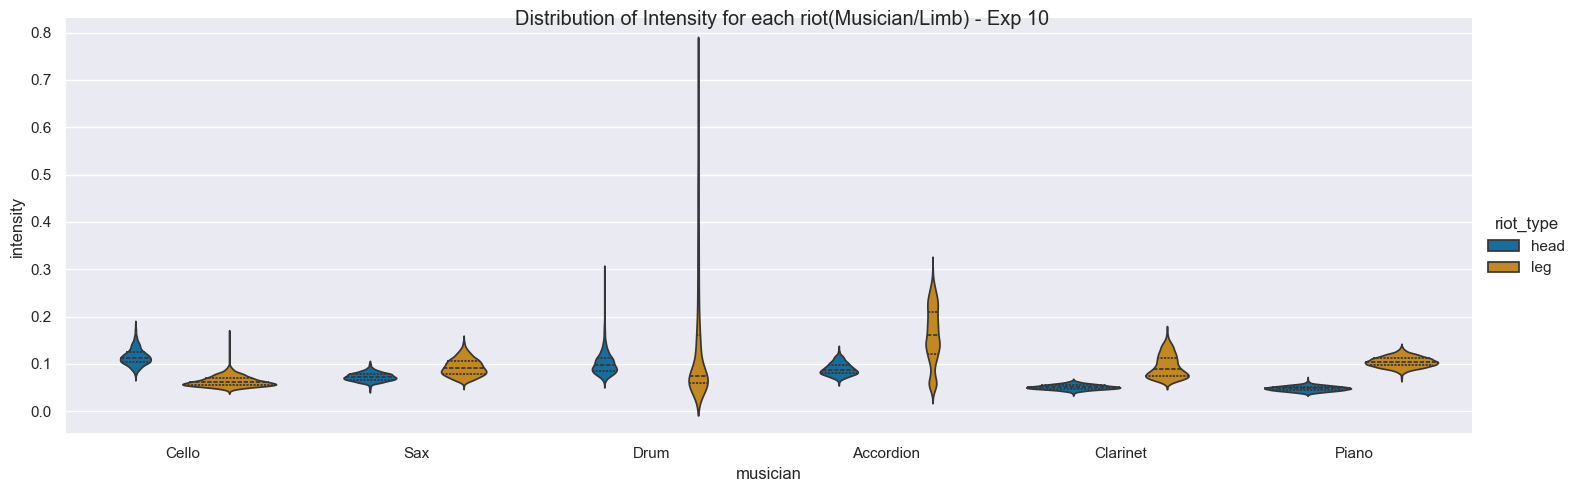

In [29]:
filtered_df_mvDistrib = df[(df['exp_n'] == 10)]

g = sns.catplot(
    data=filtered_df_mvDistrib, x="musician", y="intensity", hue="riot_type",inner="quart" ,kind="violin",aspect=3,
)

g.figure.suptitle('Distribution of Intensity for each riot(Musician/Limb) - Exp 10' )

plt.show()


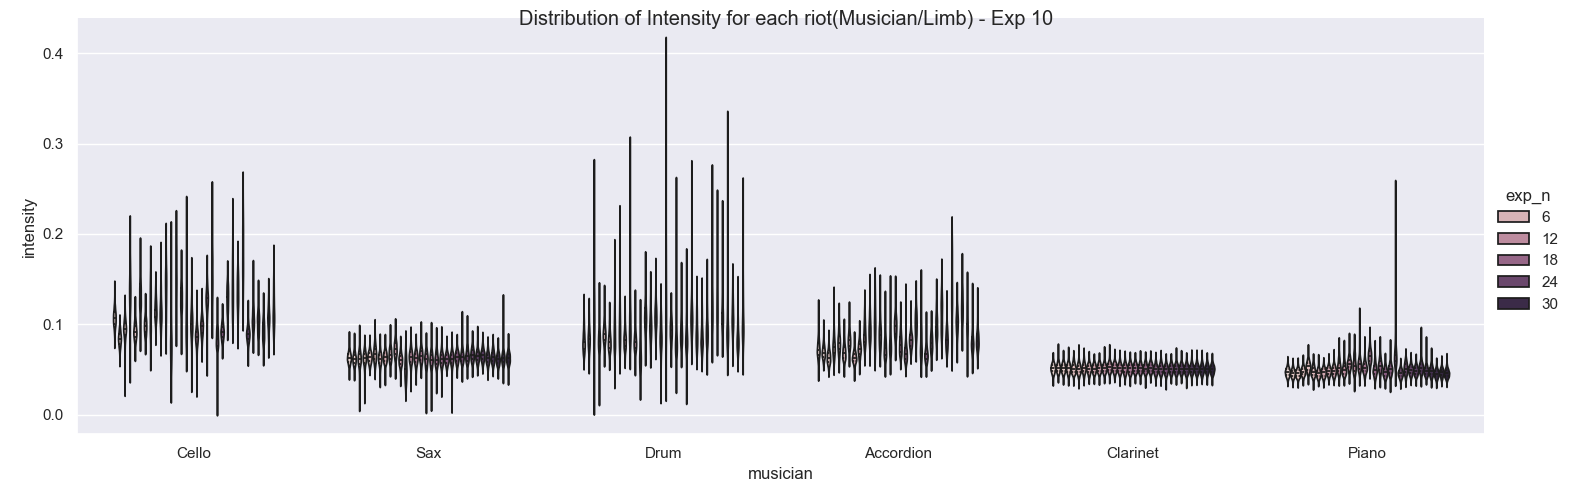

In [30]:
%matplotlib widget
filtered_df_mvDistrib = df[(df['riot_type'] == "head")]

g = sns.catplot(
    data=filtered_df_mvDistrib, x="musician", y="intensity", hue="exp_n",inner="quart" ,kind="violin",height=5,width=0.7,aspect=3,
)

g.figure.suptitle('Distribution of Intensity for each riot(Musician/Limb) - Exp 10' )

plt.show()

### Interactive Violin Plot

*How to use ?*

First, ensure you execute the code above to build and load the dataframe (Group 1), no need to manually load csv. Then, run this cell. You should wait approximately 30 seconds for the widgets to appear. Next, you can select your dataframe, trial numbers, riot type, and experiment factors, and then press 'Submit'. Press 'Reset' to clear all filters. You can group data using the 'Hue' dropdown.

(Note that the filters for all dataframe's factors are currently not working.)

In [31]:
# Interactive violin plot
%matplotlib widget
# Widgets pour les filtres

grouped_title = ""
trial_title = ""
riot_title = ""
f1_title = ""
f2_title = ""

dataframes = [click_tempo_intensity,mask_attack_intensity,change_intensity]
dataframes_str = ['click tempo', 'mask attack', 'change intensity']
selected_all = False
#worst thing to do
select_integer = -1


exp_n_widget = widgets.SelectMultiple(
    # options=sorted(df['exp_n'].unique()),
    value=[],
    description='Trial Numbers:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

riot_type_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Riot Types:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

factor1_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Complexities:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

factor2_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Parameters:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

riot_type_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Riot Types:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

# Widget pour choisir la variable de catégorisation (hue)
hue_widget = widgets.Dropdown(
    options=['exp_n', 'riot_type','factor1','factor2'],
    value='exp_n',
    description='Hue:',
)

# chage options lost values (and labels)
def update_widget_options(widget, new_options):
    current_values = widget.value 
    widget.options = sorted(new_options)
    
    new_values = tuple(value for value in current_values if value in new_options)
    widget.value = new_values


def set_title(hue_value,exp_list,riot_list,f1_list,f2_list):
    global grouped_title, trial_title, riot_title
    if hue_value == 'exp_n':
        grouped_title = 'trial'
    elif hue_value == 'riot_type':
        grouped_title = 'riot type'
    elif hue_value == 'factor1':
        grouped_title = 'complexity'
    elif hue_value == 'factor2':
        grouped_title = 'parameters'
    
    if not exp_list:
        trial_title = 'All'
    else :
        trial_title = exp_list
    if not riot_list:
        riot_title = 'All'
    else :
        riot_title = riot_list
    if not f1_list:
        f1_title = 'All'
    else :
        f1_title = exp_list
    if not f2_list:
        f2_title = 'All'
    else :
        f2_title = riot_list

def update_violin_plot(*args):
    global df, select_integer
    filtered_dfs = []

    # factor1_widget.options = sorted(df['factor1'].unique())
    # factor2_widget.options = sorted(df['factor2'].unique())
    # exp_n_widget.options = sorted(df['exp_n'].unique())
    # riot_type_widget.options=sorted(df['riot_type'].unique())


    if selected_all == True:
        # Appliquer les filtres à chaque DataFrame de la liste
        for df_i in dataframes:
            if factor1_widget.value:
                df_i = df_i[df_i['factor1'].isin(factor1_widget.value)]
            if factor2_widget.value:
                df_i = df_i[df_i['factor2'].isin(factor2_widget.value)]
            if exp_n_widget.value:
                df_i = df_i[df_i['exp_n'].isin(exp_n_widget.value)]
            if riot_type_widget.value:
                df_i = df_i[df_i['riot_type'].isin(riot_type_widget.value)]
            filtered_dfs.append(df_i)
    else:
        # Appliquer les filtres
        df_i = df.copy()
        if factor1_widget.value:
            df_i = df_i[df_i['factor1'].isin(factor1_widget.value)]
        if factor2_widget.value:
            df_i = df_i[df_i['factor2'].isin(factor2_widget.value)]
        if exp_n_widget.value:
            df_i = df_i[df_i['exp_n'].isin(exp_n_widget.value)]
        if riot_type_widget.value:
            df_i = df_i[df_i['riot_type'].isin(riot_type_widget.value)]
        filtered_dfs.append(df_i)

    #doesn't display all filters options when all dataframes are selected
    update_widget_options(factor1_widget,df_i['factor1'].unique())
    update_widget_options(factor2_widget, df_i['factor2'].unique())
    update_widget_options(exp_n_widget,df_i['exp_n'].unique())
    update_widget_options(riot_type_widget,df_i['riot_type'].unique())

    if select_integer == -1 or select_integer == 3:
        select_integer = 0

    with out:
        # plt.close('all')
        clear_output(wait=True)
        for df_i in filtered_dfs:
            sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")
            g = sns.catplot(
                data=df_i, x="musician", y="intensity", hue=hue_widget.value,
                palette="colorblind",
                kind="boxen",
                # kind="violin",
                # inner="quart",
                aspect=3,
            )
            set_title(hue_widget.value, exp_n_widget.label, riot_type_widget.label,factor1_widget.label,factor2_widget.label)
            g.figure.suptitle('Distribution of Intensity for each Musician Grouped by {} - {} - Filtered by Trial: {}, Riot Type: {}, Complexity: {}, Parameter: {}'.format(
                grouped_title,dataframes_str[select_integer], trial_title, riot_title,f1_title,f2_title
            ))
            g.set(ylim=(0, 1))

            # plt.savefig('violinplot.svg')
            plt.show()

            select_integer = select_integer + 1
#Chosir dataframe correspondant à la session
def update_df(selected_df):
    global df, selected_all, select_integer
    if selected_df == 'click tempo':
        df = click_tempo_intensity
        select_integer = 0
        selected_all = False
    elif selected_df == 'mask attack':
        df = mask_attack_intensity
        select_integer = 1
        selected_all = False
    elif selected_df == 'change':
        df = change_intensity
        select_integer = 2
        selected_all = False
    else:
        # df = pd.DataFrame()  # Réinitialise df si aucune sélection valide
        selected_all = True
        select_integer = -1
    update_violin_plot()

# Création du widget dropdown pour la sélection du DataFrame
df_selector = interactive(update_df, selected_df=['all','click tempo', 'mask attack', 'change'])


# Observeur pour la mise à jour UPDATE : Via Submit
# exp_n_widget.observe(update_violin_plot, 'value')
# riot_type_widget.observe(update_violin_plot, 'value')
# hue_widget.observe(update_violin_plot, 'value')
# factor1_widget.observe(update_violin_plot, 'value')
# factor2_widget.observe(update_violin_plot, 'value')

# Submit Button
submit_button = widgets.Button(description="Submit")
submit_button.on_click(update_violin_plot)

# Boutton Reset
reset_button = widgets.Button(description="Reset")
def on_reset_button_clicked(b):
    # Réinitialiser les valeurs des widgets à toutes les options sélectionnées
    print('reset')
    factor1_widget.value = ()
    factor2_widget.value = ()
    exp_n_widget.value = ()
    riot_type_widget.value = ()
    # factor1_widget.options = sorted(df['factor1'].unique())
    # factor2_widget.options = sorted(df['factor2'].unique())
    # riot_type_widget.options=sorted(df['riot_type'].unique())
    # exp_n_widget.options = sorted(df['exp_n'].unique())
    update_violin_plot()
reset_button.on_click(on_reset_button_clicked)

# Zone d'affichage pour le graphique
out = widgets.Output()

# Initialisation de l'affichage du graphique
update_violin_plot()

# Organiser et afficher les widgets
widgets_ui = widgets.VBox([df_selector,widgets.HBox([exp_n_widget, riot_type_widget]),widgets.HBox([factor1_widget,factor2_widget]), hue_widget
                           ,submit_button
                           ,reset_button
                           , out])
display(widgets_ui)

In [32]:
# update_df('click_tempo')

# # Appliquer les filtres
# df_i = df.copy()

# sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")
# g = sns.catplot(
#     data=df_i, x="musician", y="intensity", hue='exp_n',
#     palette="colorblind",
#     kind="violin", inner="quart", aspect=3,
# )
# set_title(hue_widget.value, [], [])
# g.figure.suptitle('Distribution of Intensity for each Musician Grouped by {} - Filtered by Trial: {}, Riot Type: {}'.format(
#     grouped_title, trial_title, riot_title
# ))
# g.set(ylim=(0, 1))

# # plt.savefig('violinplot.svg')
# plt.show()

### Mean Motion per Condition

#### Click Tempo

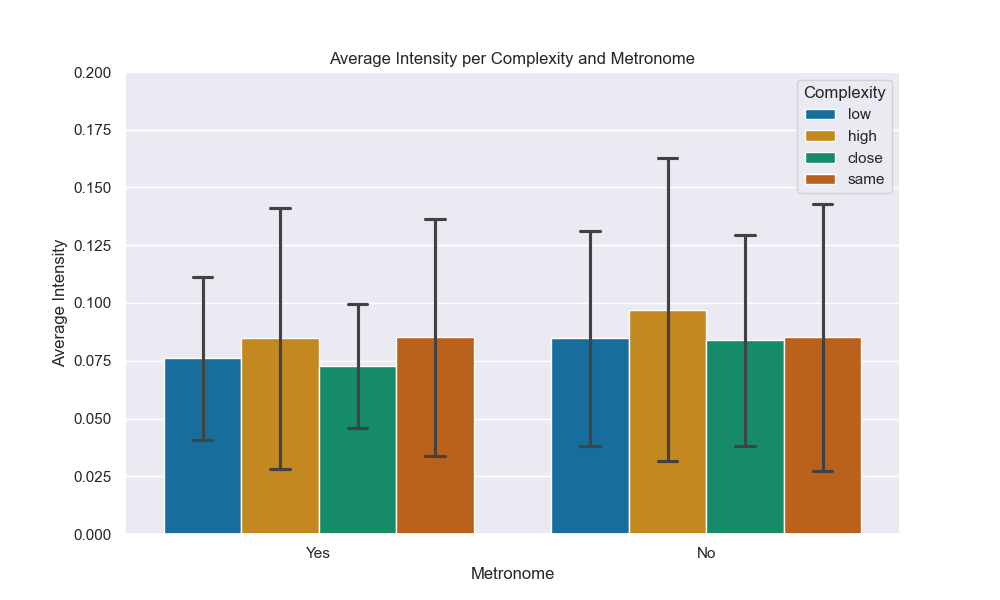

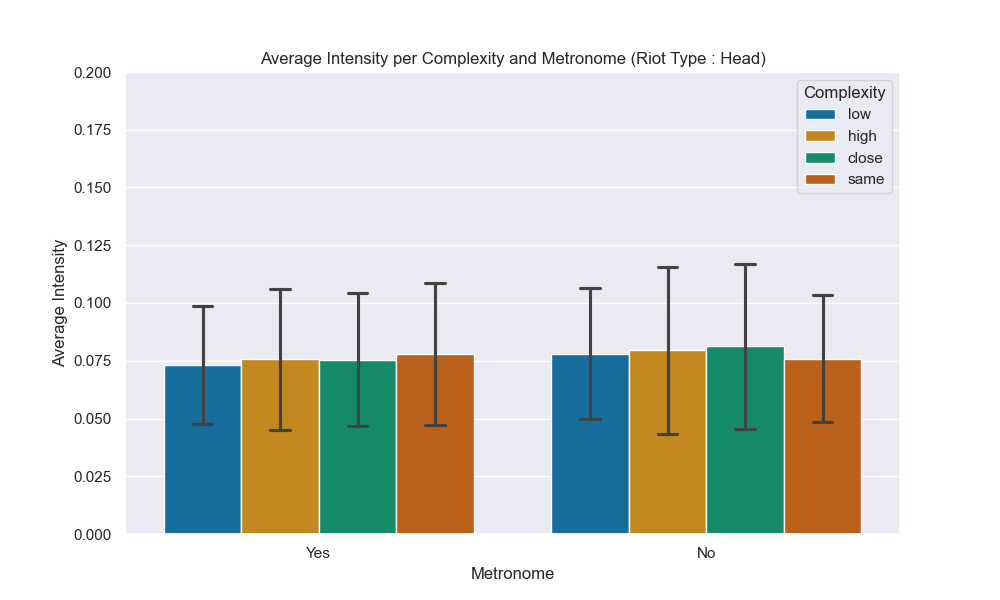

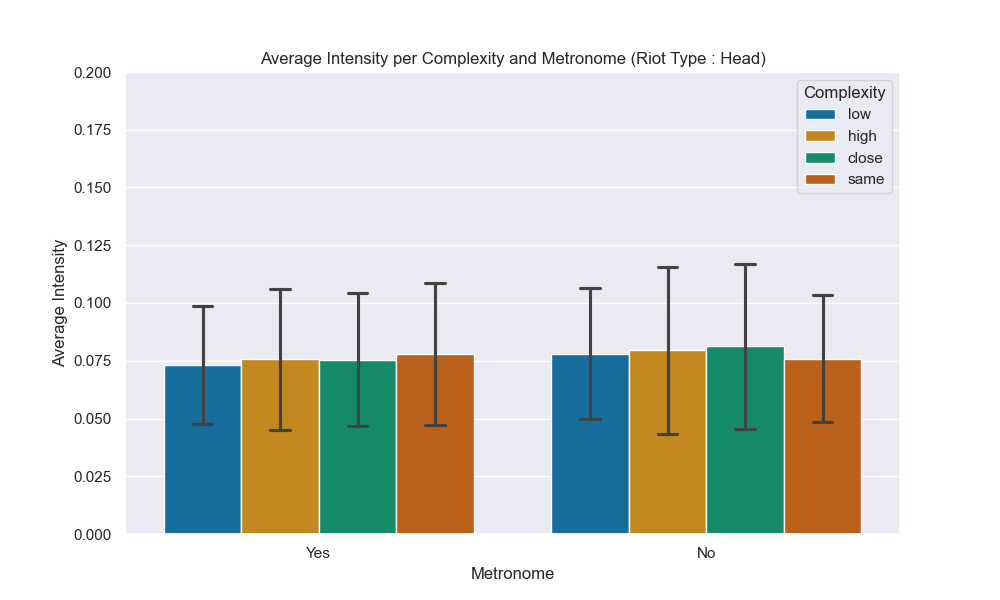

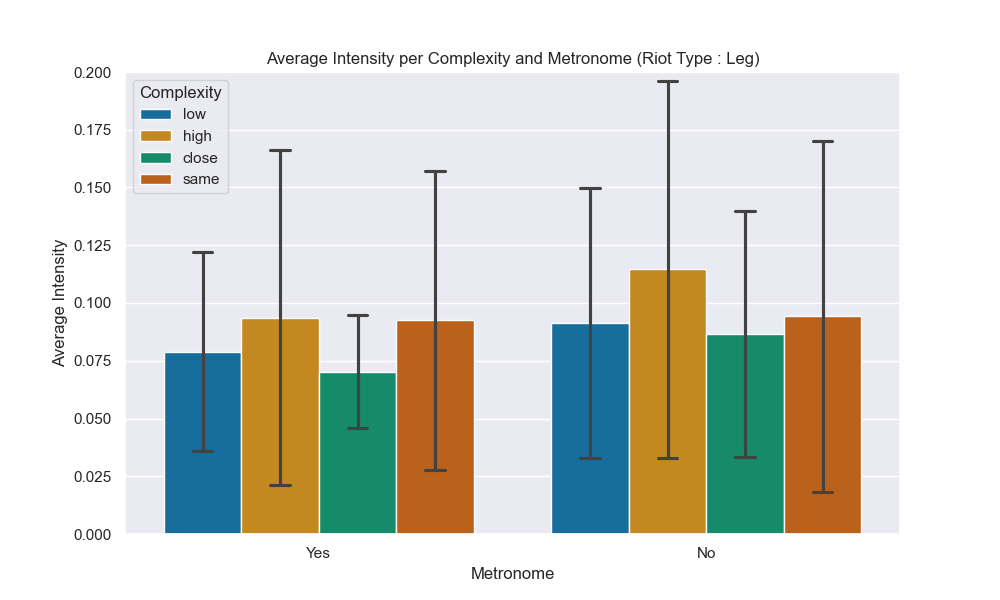

In [33]:
df = click_tempo_intensity

# grouped = df.groupby(['factor1', 'factor2'])['intensity'].agg(['mean', 'sem']).reset_index()

# Maintenant, créons le bar plot avec Seaborn
plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
# sns.boxplot(data=df, x='factor2', y='intensity',
#             # estimator='mean',errorbar=("sd"),
#               hue='factor1')
#             #   , capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',
            estimator='mean',errorbar=("sd"),
              hue='factor1'
              , capsize=.2)
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and Metronome')
plt.xlabel('Metronome')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

df = click_tempo_intensity[(click_tempo_intensity['riot_type'] == 'head')].copy()

plt.figure(figsize=(10, 6))
axs = sns.barplot(data=df, x='factor2', y='intensity',
            estimator='mean',errorbar=("sd"),
              hue='factor1'
              , capsize=.2)
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and Metronome (Riot Type : Head)')
plt.xlabel('Metronome')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

df = click_tempo_intensity

# grouped = df.groupby(['factor1', 'factor2'])['intensity'].agg(['mean', 'sem']).reset_index()

plt.show()

df = click_tempo_intensity[(click_tempo_intensity['riot_type'] == ('leg'))]

plt.figure(figsize=(10, 6))
axs = sns.barplot(data=df, x='factor2', y='intensity',
            estimator='mean',errorbar=("sd"),
              hue='factor1'
              , capsize=.2)
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and Metronome (Riot Type : Leg)')
plt.xlabel('Metronome')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

df = click_tempo_intensity

grouped = df.groupby(['factor1', 'factor2'])['intensity'].agg(['mean', 'sem']).reset_index()

Fichier chargé avec succès. Aperçu des données :


,t,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,...,accfilt_x,accfilt_y,accfilt_z,intensity,exp_n,riot_n,musician,riot_type,factor1,factor2
0,5196.236472,-0.004150,-0.555420,0.746338,-0.005005,-0.001648,0.001770,1.539795,0.234253,1.245239,...,-0.012817,-0.002780,-0.009403,0.089766,10,0,Cello,head,low,Yes
1,5206.236472,-0.031982,-0.571045,0.723633,-0.005798,-0.001404,0.001709,1.539795,0.234253,1.245239,...,-0.008782,-0.004121,-0.008963,0.087023,10,0,Cello,head,low,Yes
2,5216.236472,-0.017578,-0.565918,0.776611,-0.006531,-0.002441,0.002502,1.539795,0.234253,1.245239,...,-0.007897,-0.006532,-0.002533,0.091008,10,0,Cello,head,low,Yes
3,5226.236472,0.006592,-0.596436,0.711426,-0.006958,-0.002136,0.004211,1.538574,0.235840,1.242371,...,0.000222,-0.012107,-0.000394,0.088336,10,0,Cello,head,low,Yes
4,5236.236472,-0.024658,-0.618896,0.697998,-0.008179,-0.003296,0.005554,1.538574,0.235840,1.242371,...,0.004142,-0.024210,-0.013088,0.091445,10,0,Cello,head,low,Yes


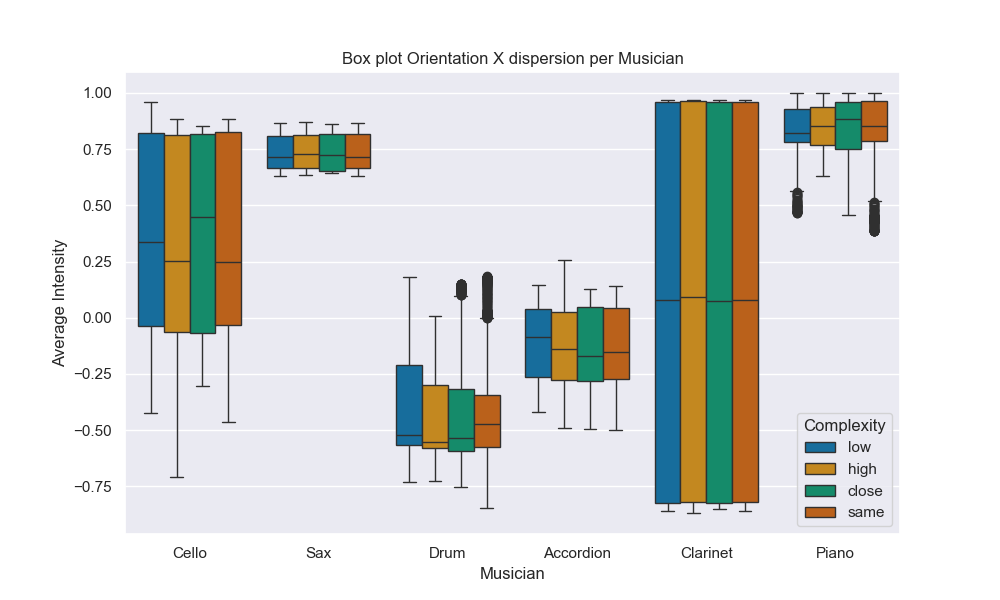

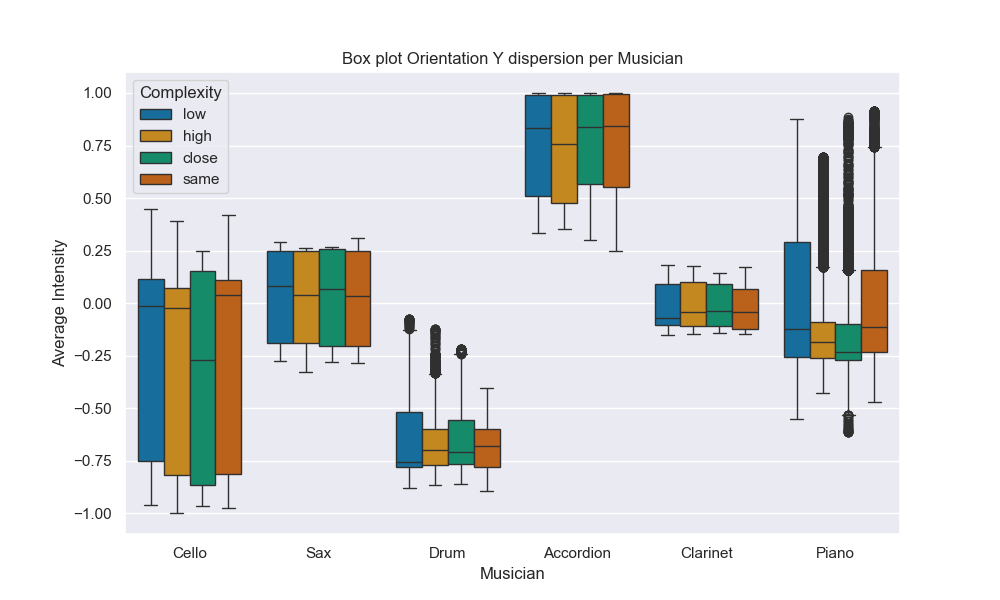

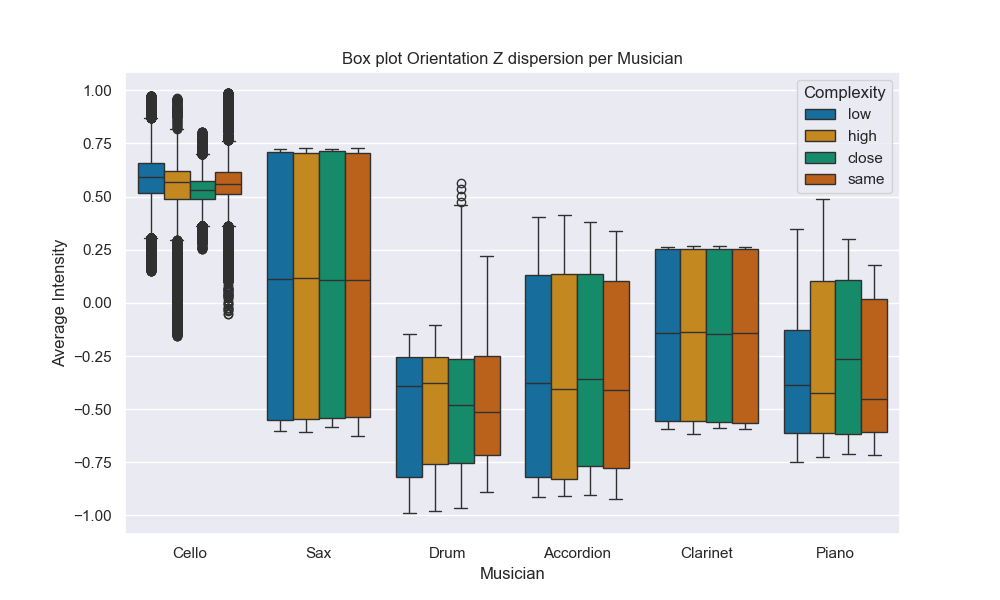

In [34]:


df = click_tempo_all = load_csv("click_tempo_all.csv")

# Maintenant, créons le bar plot avec Seaborn
plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
sns.boxplot(data=df, x='musician', y='orientation_x',
            # estimator='mean',errorbar=("sd"),
              hue='factor1')
            #   , capsize=.2)

plt.title('Box plot Orientation X dispersion per Musician')
plt.xlabel('Musician')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
sns.boxplot(data=df, x='musician', y='orientation_y',
            # estimator='mean',errorbar=("sd"),
              hue='factor1')
            #   , capsize=.2)

plt.title('Box plot Orientation Y dispersion per Musician')
plt.xlabel('Musician')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
sns.boxplot(data=df, x='musician', y='orientation_z',
            # estimator='mean',errorbar=("sd"),
              hue='factor1')
            #   , capsize=.2)

plt.title('Box plot Orientation Z dispersion per Musician')
plt.xlabel('Musician')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

#### Mask Attack

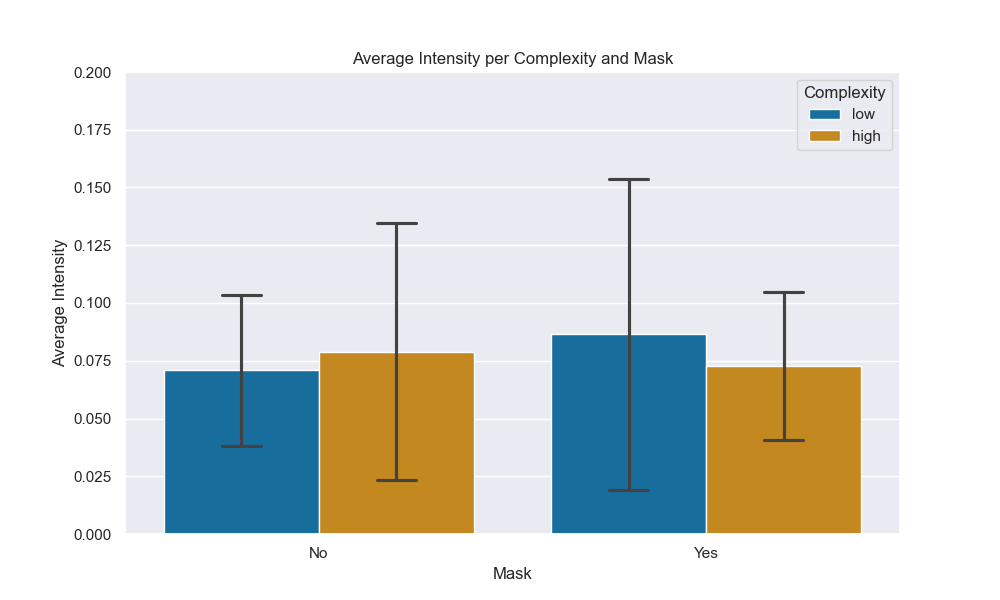

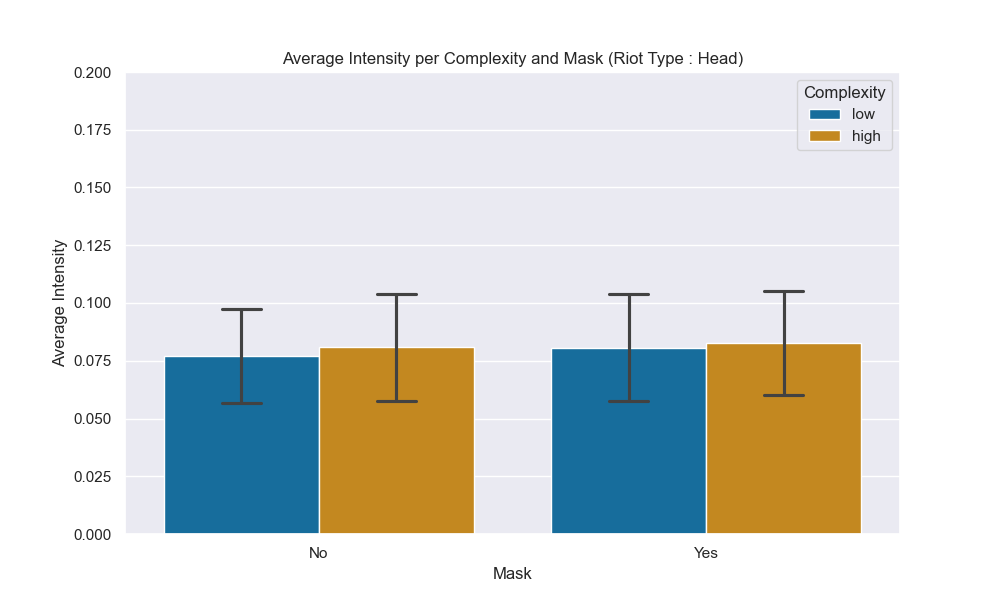

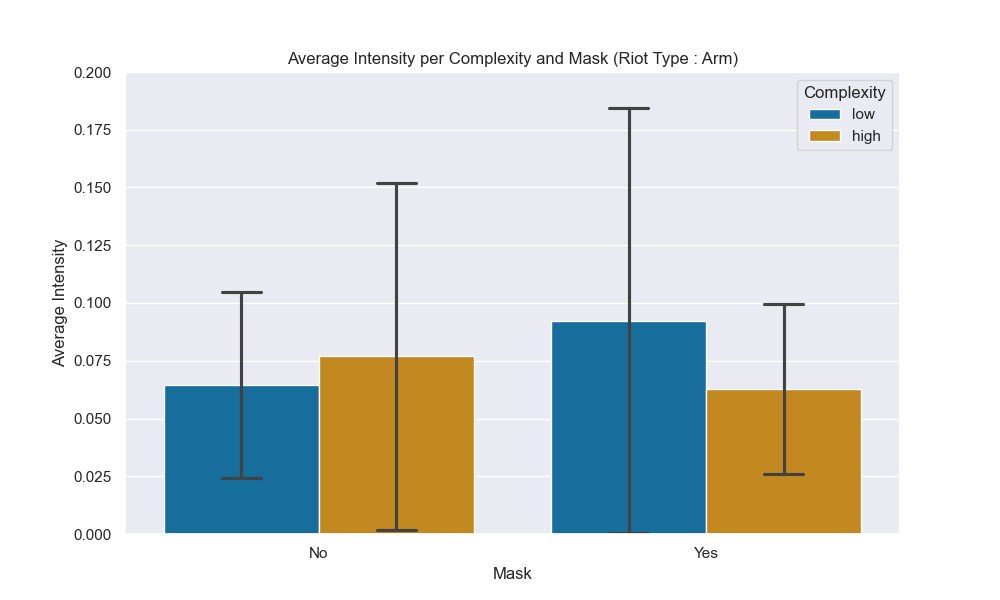

In [35]:
df = mask_attack_intensity

# grouped = df.groupby(['factor1', 'factor2'])['intensity'].agg(['mean', 'sem']).reset_index()

# Maintenant, créons le bar plot avec Seaborn
plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',estimator='mean',errorbar=("sd"), hue='factor1', capsize=.2)
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and Mask')
plt.xlabel('Mask')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

df = mask_attack_intensity[(mask_attack_intensity['riot_type'] == ('head'))].copy()

# grouped = df.groupby(['factor1', 'factor2'])['intensity'].agg(['mean', 'sem']).reset_index()

# Maintenant, créons le bar plot avec Seaborn
plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',estimator='mean',errorbar=("sd"), hue='factor1', capsize=.2)
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and Mask (Riot Type : Head)')
plt.xlabel('Mask')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()


df = mask_attack_intensity[(mask_attack_intensity['riot_type'] == ('arm'))].copy()

# grouped = df.groupby(['factor1', 'factor2'])['intensity'].agg(['mean', 'sem']).reset_index()

# Maintenant, créons le bar plot avec Seaborn
plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',estimator='mean',errorbar=("sd"), hue='factor1', capsize=.2)
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and Mask (Riot Type : Arm)')
plt.xlabel('Mask')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

#### Change

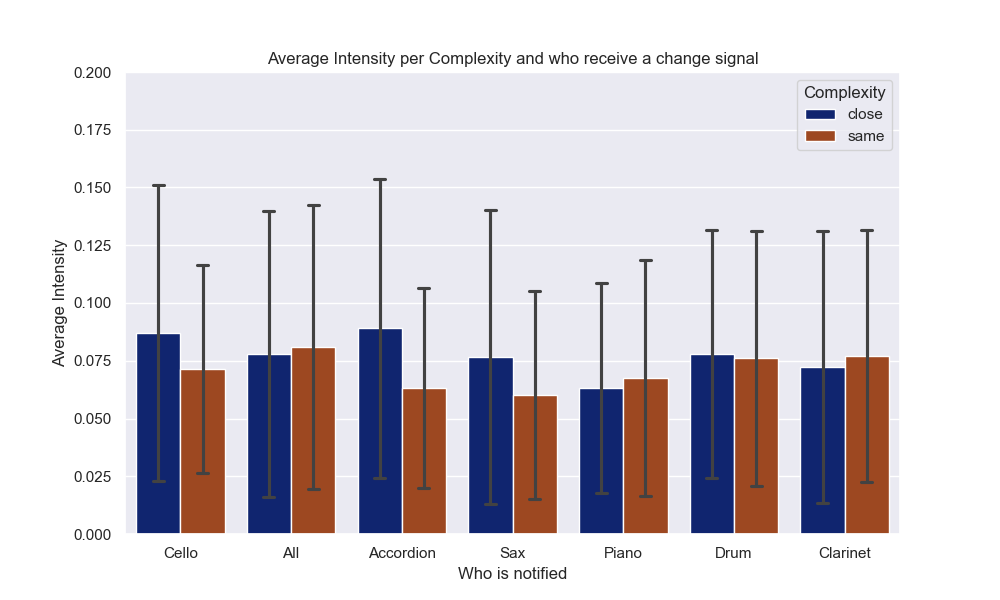

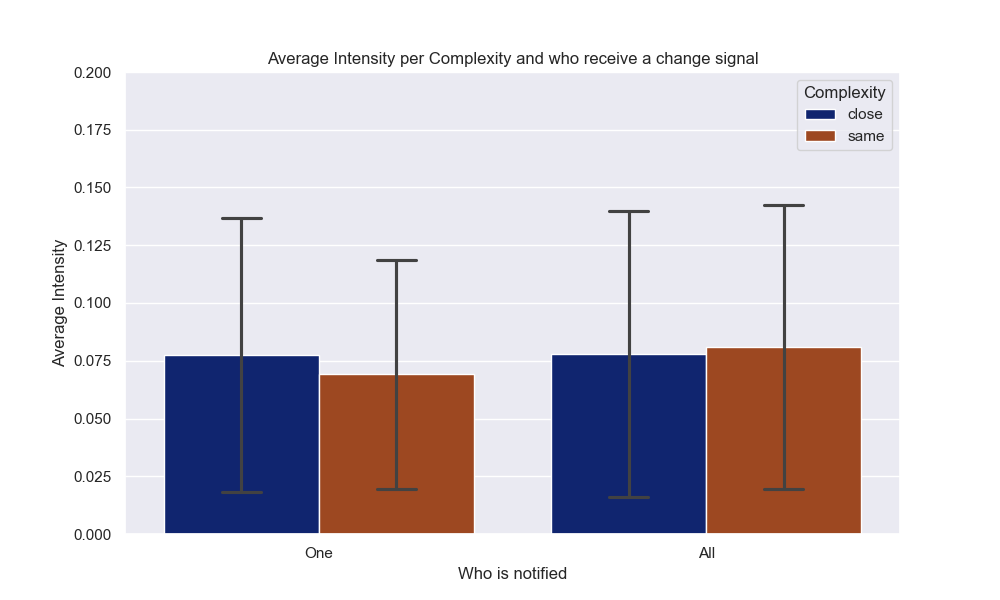

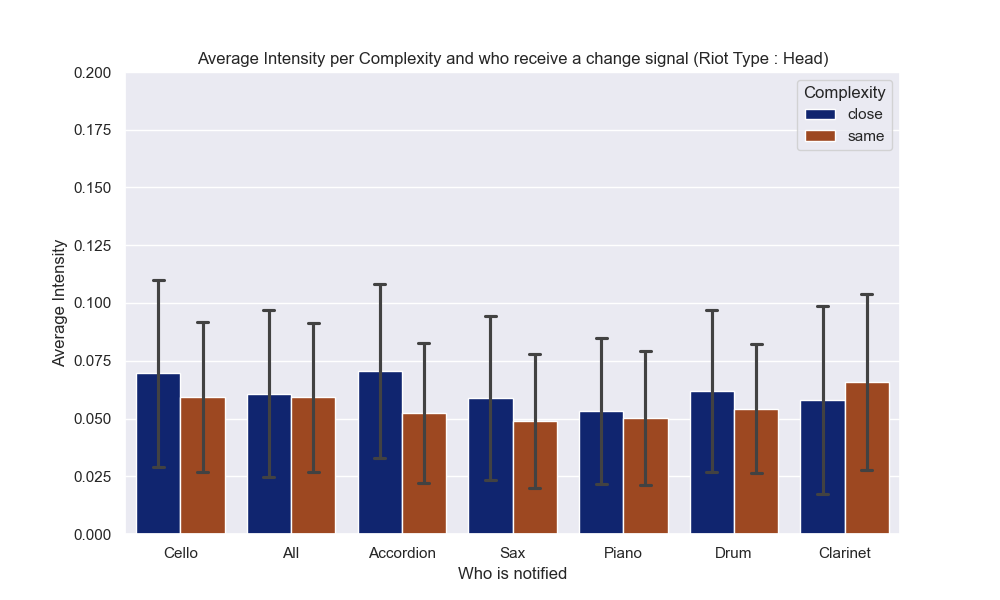

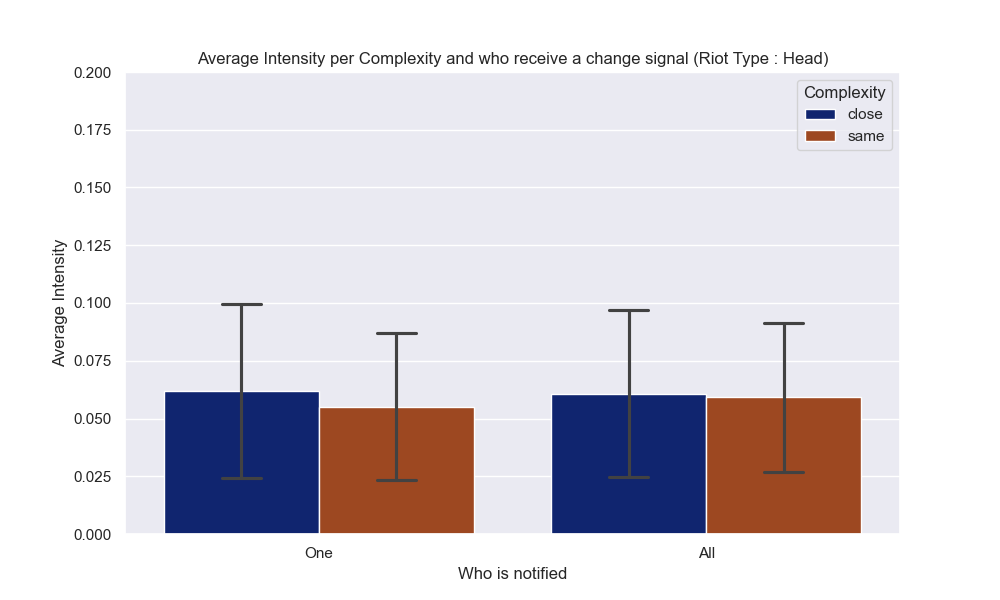

C:\Users\haron\AppData\Local\Temp\ipykernel_17568\2433147143.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


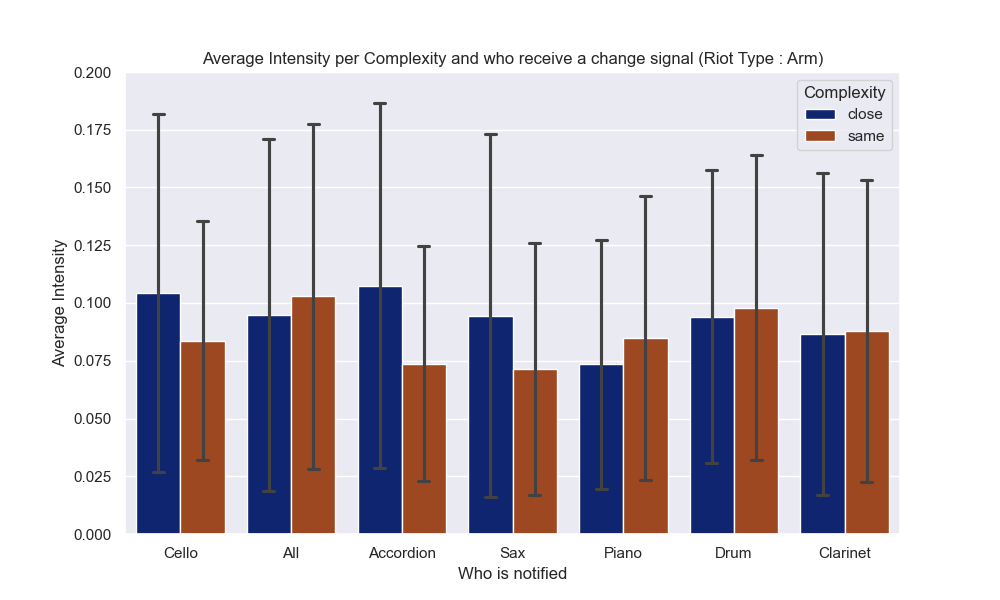

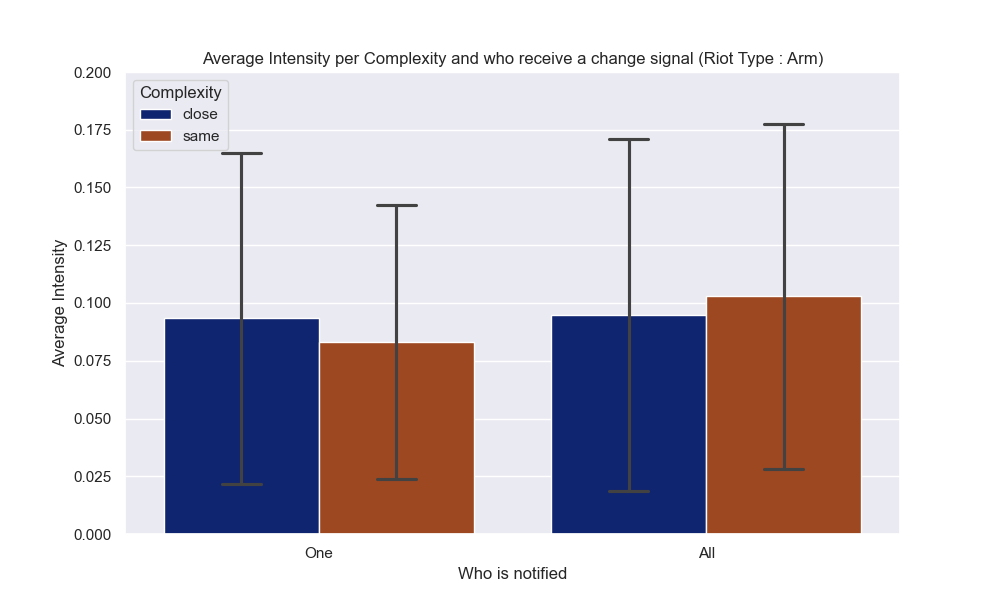

In [36]:
df = change_intensity

# grouped = df.groupby(['factor1', 'factor2'])['intensity'].agg(['mean', 'sem']).reset_index()

# Maintenant, créons le bar plot avec Seaborn
plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',estimator='mean',errorbar=("sd"), hue='factor1', capsize=.2,palette="dark")
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and who receive a change signal')
plt.xlabel('Who is notified')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

# One vs All

df = change_intensity.copy()

df['factor2'] = np.where(df['factor2'] != 'All', 'One', df['factor2'])

plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',estimator='mean',errorbar=("sd"), hue='factor1', capsize=.2,palette="dark")
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and who receive a change signal')
plt.xlabel('Who is notified')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

df = change_intensity[(change_intensity['riot_type'] == 'head')].copy()

# grouped = df.groupby(['factor1', 'factor2'])['intensity'].agg(['mean', 'sem']).reset_index()

# Maintenant, créons le bar plot avec Seaborn
plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',estimator='mean',errorbar=("sd"), hue='factor1', capsize=.2,palette="dark")
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and who receive a change signal (Riot Type : Head)')
plt.xlabel('Who is notified')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

# One vs All

df = change_intensity[(change_intensity['riot_type'] == 'head')].copy()

df['factor2'] = np.where(df['factor2'] != 'All', 'One', df['factor2'])

plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',estimator='mean',errorbar=("sd"), hue='factor1', capsize=.2,palette="dark")
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and who receive a change signal (Riot Type : Head)')
plt.xlabel('Who is notified')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

df = change_intensity[(change_intensity['riot_type'] == 'arm')].copy()
# grouped = df.groupby(['factor1', 'factor2'])['intensity'].agg(['mean', 'sem']).reset_index()

# Maintenant, créons le bar plot avec Seaborn
plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',estimator='mean',errorbar=("sd"), hue='factor1', capsize=.2,palette="dark")
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and who receive a change signal (Riot Type : Arm)')
plt.xlabel('Who is notified')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

# One vs All

df = change_intensity[(change_intensity['riot_type'] == 'arm')].copy()

df['factor2'] = np.where(df['factor2'] != 'All', 'One', df['factor2'])

plt.figure(figsize=(10, 6))
# sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
axs = sns.barplot(data=df, x='factor2', y='intensity',estimator='mean',errorbar=("sd"), hue='factor1', capsize=.2,palette="dark")
axs.set_ylim(0,0.2)
plt.title('Average Intensity per Complexity and who receive a change signal (Riot Type : Arm)')
plt.xlabel('Who is notified')
plt.ylabel('Average Intensity')
plt.legend(title='Complexity')

plt.show()

In [37]:
#Chosir dataframe correspondant à la session
def update_df(selected_df):
    global df
    if selected_df == 'click tempo':
        df = click_tempo_intensity
    elif selected_df == 'mask attack':
        df = mask_attack_intensity
    elif selected_df == 'change intensity':
        df = change_intensity
    else:
        df = pd.DataFrame()  # Réinitialise df si aucune sélection valide
    update_violin_plot()

# Création du widget dropdown pour la sélection du DataFrame
df_selector = interactive(update_df, selected_df=['click tempo', 'mask attack', 'change intensity'])



### Tempis


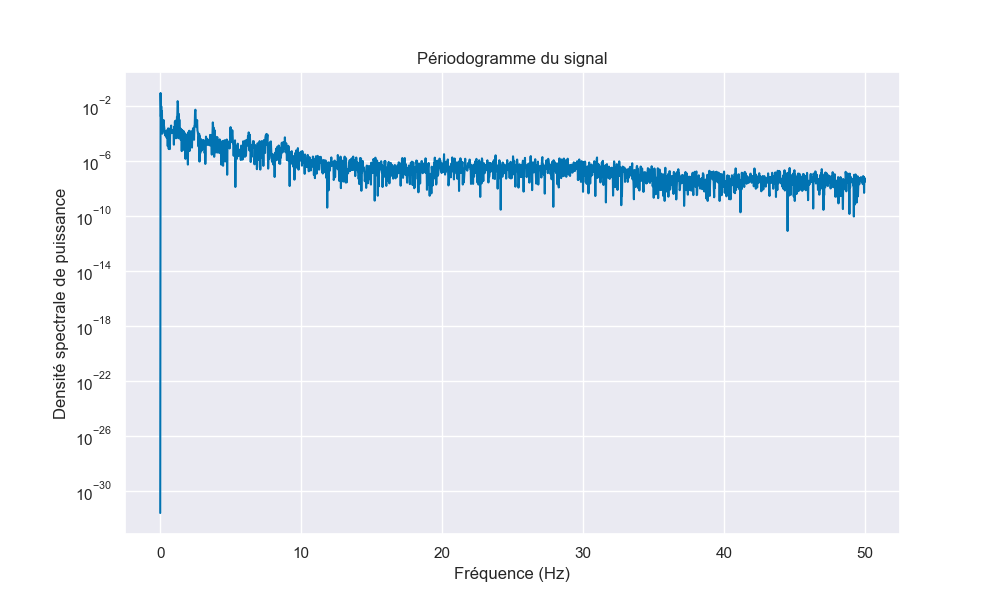

In [38]:
# df = change_intensity[(change_intensity['musician'] == 'Cello') & (change_intensity['riot_type'] == 'arm') & (change_intensity['exp_n'] == 10)]
# df = df['intensity'].to_numpy()

# plt.figure(figsize=(12,8))
# Tgram = librosa.feature.tempogram(y=df, sr=10000)
# librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
# plt.colorbar()
# plt.title('Tempogram')
# plt.show()

df = change_intensity[(change_intensity['musician'] == 'Cello') & (change_intensity['riot_type'] == 'arm') & (change_intensity['exp_n'] == 10)]
df = df['intensity'].to_numpy()

from scipy  import signal

frequencies, power =  signal.periodogram(df, 100)

# Affichage du périodogramme
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, power)
plt.title('Périodogramme du signal')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')
plt.grid(True)
plt.show()

# import numpy as np


# signal = filtered_df_Cello['intensity'].to_numpy()
# # Normalisation du signal
# signal = signal - np.mean(signal)
# signal = signal / np.max(np.abs(signal))

# # Définir le taux d'échantillonnage
# sr = 100  # Le taux d'échantillonnage est de 100 Hz
# # tempo, _ = librosa.beat.beat_track(y=signal, sr=sr, tightness=100, trim=False)
# # Utiliser librosa.beat.tempo pour estimer le tempo global du signal
# # On utilise aggregate=None pour obtenir la distribution de tous les tempos estimés plutôt qu'un seul tempo global
# tempo_distribution = librosa.beat.tempo(y=signal, sr=sr, aggregate=None)

# # Visualiser la distribution du tempo
# plt.figure(figsize=(10, 6))
# plt.hist(tempo_distribution, bins=30, color='blue', alpha=0.7)
# plt.title('Distribution du Tempo')
# plt.xlabel('Tempo (battements par minute)')
# plt.ylabel('Fréquence')
# plt.show()

## TODO
